# Music Genre Lyric Classification

Goal: Explore and apply machine learning techniques to create a model that will classify the genre of a song based on the lyrics of the song

Are lyrics alone enough to tell what genre a song is?

---

Objectives:
* Gather music data (song titles, artists, lyrics, genres)
* Implement Machine Learning algorithms/techniques to classify different music lyrics from the lyric data
* Potentially visualize data/findings

In [62]:
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

Using TensorFlow backend.


## Dataset(s)

Finding a data set with both lyrics AND genres was difficult, but I was able to finally find one on Kaggle! It contains song lyrics from 6 musical genres.

In [32]:
df_genres = pd.read_csv("tcc_ceds_music.csv")

In [33]:
df_genres.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


Let's drop the unnecessary columns not being used for classification. We are only considering lyrics in this project, so most of the columns will not be used. Because the other columns are not being used as features and the artist's names and the track names don't affect our features, those will be dropped as well!

In [34]:
df = df_genres[['genre','lyrics']].copy()

Also, it's good practice to drop any duplicates there may be!

In [35]:
df.drop_duplicates(inplace=True)

In [36]:
df.duplicated().value_counts()

False    28372
dtype: int64

In [79]:
df.head()

,genre,lyrics
0,pop,hold time feel break feel untrue convince spea...
1,pop,believe drop rain fall grow believe darkest ni...
2,pop,sweetheart send letter goodbye secret feel bet...
3,pop,kiss lips want stroll charm mambo chacha merin...
4,pop,till darling till matter know till dream live ...


In [84]:
df['lyrics_length'] = df['lyrics'].apply(len)
df

,genre,lyrics,lyrics_length
0,pop,hold time feel break feel untrue convince spea...,522
1,pop,believe drop rain fall grow believe darkest ni...,316
2,pop,sweetheart send letter goodbye secret feel bet...,153
3,pop,kiss lips want stroll charm mambo chacha merin...,314
4,pop,till darling till matter know till dream live ...,273
...,...,...,...
28367,hip hop,cause fuck leave scar tick tock clock come kno...,476
28368,hip hop,minks things chain ring braclets yap fame come...,400
28369,hip hop,get ban get ban stick crack relax plan attack ...,490
28370,hip hop,check check yeah yeah hear thing call switch g...,397


In [85]:
df.groupby('genre').size()

genre
blues      4604
country    5445
hip hop     904
jazz       3845
pop        7042
reggae     2498
rock       4034
dtype: int64

In [45]:
df.genre.value_counts()

pop        7042
country    5445
blues      4604
rock       4034
jazz       3845
reggae     2498
hip hop     904
Name: genre, dtype: int64

<AxesSubplot:>

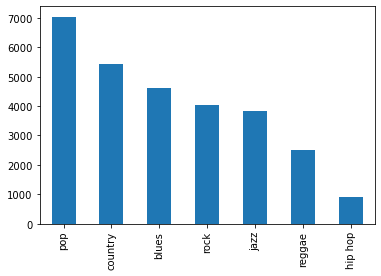

In [78]:
df.genre.value_counts().plot.bar()

In [64]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['lyrics'], df['genre'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()

train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [65]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['lyrics'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

## Feature Extraction w/ tf-idf

In [66]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['lyrics'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df['lyrics'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df['lyrics'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

C:\Users\mcken\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:506: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


## Creating and Implementing Naive Bayes, Linear Classifier and an SVM

In [67]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [69]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.37501762300860003
NB, WordLevel TF-IDF:  0.3678274354997885
NB, N-Gram Vectors:  0.29677146482447486
NB, CharLevel Vectors:  0.34808966586775697


In [71]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy)

C:\Users\mcken\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR, Count Vectors:  0.3428732553221486


C:\Users\mcken\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR, WordLevel TF-IDF:  0.38573241223741717


C:\Users\mcken\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR, N-Gram Vectors:  0.29395178344847034
LR, CharLevel Vectors:  0.38573241223741717


C:\Users\mcken\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [73]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.30565346115888903


The results were not great with any of the models used... It looks like the Logistic Regression Model at the Word Level and Char Level generated the best results, but ~40% accuracy is still not ideal.

Final thoughts: Although the accuracy results of all the models implemented are quite disappointing and do not meet my original success criteria outlined in my proposal, they do make quite a bit of sense. Text classification and prediction of normal (standard) text into groups such as news articles, reviews, etc., is already a difficult task. These tasks also typically take into account other labels as well and introduce text tokenization, lemmatization, and the removal of stop words. With music lyrics, there is context or lack there of due to the poetic prose of music lyrics. This can make the removal of stop words or lemmatization of the words in the lyrics pointless. Many other music genre classification projects I researched based their labels off the actual audio of the songs or the musical features such as BPM, danceability, mode, etc,. instead of taking into lyrics at all. The accuracy of those projects were much higher than what this project achieved, which makes more sense when taking into account the labels considered and what classifies a music genre.

In the future, I'd like to make an attempt to make a classier based off the musicality AND the lyrics to find genre instead of one or the other. The difficulty with this is finding the proper datasets, but it may take me creating my own and learning more about API use and web scraping. 